# Image Postprocessing of Cavitation Images

This program loads images from Photron BC2HD and tests the background correction

    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2024 D.Duke
    @license GPL-3.0+
    @version 0.0.1
    @date 24/04/2024
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia


In [79]:
from pySciCam.pySciCam import ImageSequence # https://github.com/djorlando24/pySciCam
import numpy as np
import glob, sys, os, copy
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
# Define where images come from.
source_images = "/Users/dduke//Downloads/FarField_PartialCavitation_20240419/raw"
source_bkgnd = "/Users/dduke//Downloads/FarField_PartialCavitation_20240419/bg"

In [173]:
# Read in images.
B=ImageSequence(source_bkgnd, monochrome=False)
I=ImageSequence(source_images, monochrome=False)

Reading /Users/dduke//Downloads/FarField_PartialCavitation_20240419/bg
	Found 100 images with extension .tif
	PythonMagick thinks the bit depth is uint12
	Reading files into memory...
8 tasks on 8 processors


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    1.8s remaining:    6.3s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    2.1s remaining:    2.6s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    2.5s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    2.8s finished


Read 421.9 MiB in 3.3 sec
	Data in memory:	 (100, 3, 480, 2048)
	Intensity range:	 0 to 18761 	 uint16
	Array size:	562.5 MB
Reading /Users/dduke//Downloads/FarField_PartialCavitation_20240419/raw
	Found 101 images with extension .tif
	PythonMagick thinks the bit depth is uint12
	Reading files into memory...
8 tasks on 8 processors


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   9 | elapsed:    1.0s remaining:    3.6s
[Parallel(n_jobs=8)]: Done   4 out of   9 | elapsed:    1.3s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   6 out of   9 | elapsed:    1.6s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:    1.9s finished


Read 426.1 MiB in 2.4 sec
	Data in memory:	 (101, 3, 480, 2048)
	Intensity range:	 0 to 18761 	 uint16
	Array size:	568.1 MB


In [174]:
# Convert array to a colour RGB format that imshow likes.
def mplColor(I):
    return np.roll(np.rollaxis(I,0,3),2,2)/np.nanmax(I)

## Background Corrections

In [182]:
# Time-average background
Bavg = np.mean(B.arr,axis=0)

# Background color removal (sum of R+G+B signals. Allow R+B to be 8x as bright as G due to Bayer mask.)
# The Bayer mask factor should probably be 2, but I made it 8 for artificial enhancement.
Bavg_mono = 8*Bavg[0,...]+8*Bavg[1,...]+Bavg[2,...]

# Boost the minimum level to avoid division by zero later.
# The number chosen for the mask here is arbitrary.
# I let it be 1% of the max intensity.
threshold=0.01*np.nanmax(Bavg_mono)
print("The raw counts for the threshold is: %i" % threshold)
Bavg_monoAdj = Bavg_mono[...]
Bavg_monoAdj[Bavg_monoAdj<threshold]=threshold
print("Background time-average min=%i, max=%i counts" % (Bavg_monoAdj.min(),Bavg_monoAdj.max()))

The raw counts for the threshold is: 1504
Background time-average min=1504, max=150432 counts


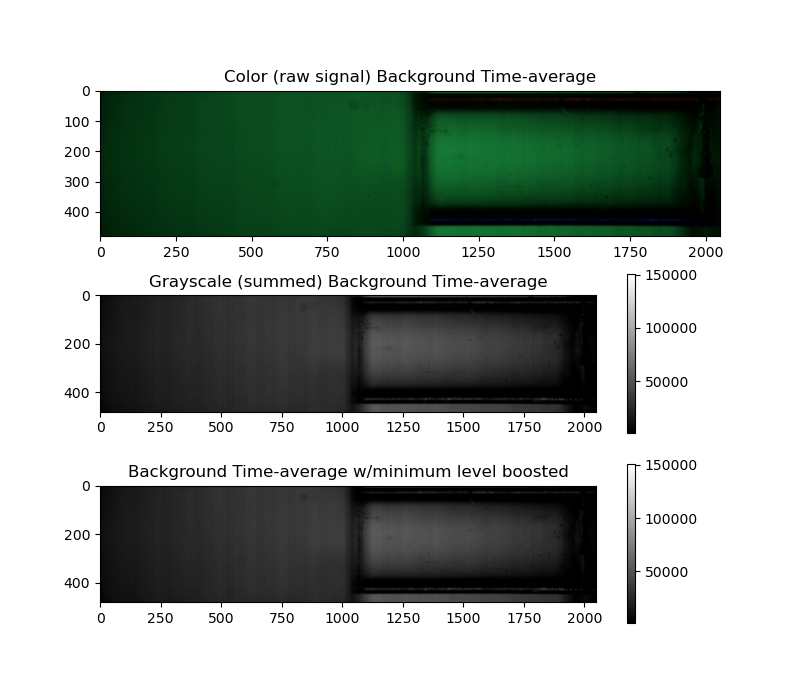

In [183]:
# Plot our progress.
fig=plt.figure(figsize=(8,7))
ax=fig.add_subplot(311)
ax.set_title("Color (raw signal) Background Time-average")
ax.imshow(mplColor(Bavg))
ax=fig.add_subplot(312)
ax.set_title("Grayscale (summed) Background Time-average")
p=ax.imshow(Bavg_mono,cmap='grey')
plt.colorbar(p)
ax=fig.add_subplot(313)
ax.set_title("Background Time-average w/minimum level boosted")
p=ax.imshow(Bavg_monoAdj,cmap='grey')
plt.colorbar(p);

# Background Removal

In [186]:
# First get the RGB sum of foreground images
# Allow R+B to be 8x as bright as G due to Bayer mask (also cos they're weaker)
# The Bayer mask factor should probably be 2, but I made it 8 for artificial enhancement.
Imono = 8*I.arr[:,0,...]+8*I.arr[:,1,...]+I.arr[:,2,...]
#Imono =  np.sum(I.arr,axis=1)

# Now remove the average background
Iproc = 1.0 - (Imono / Bavg_monoAdj)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


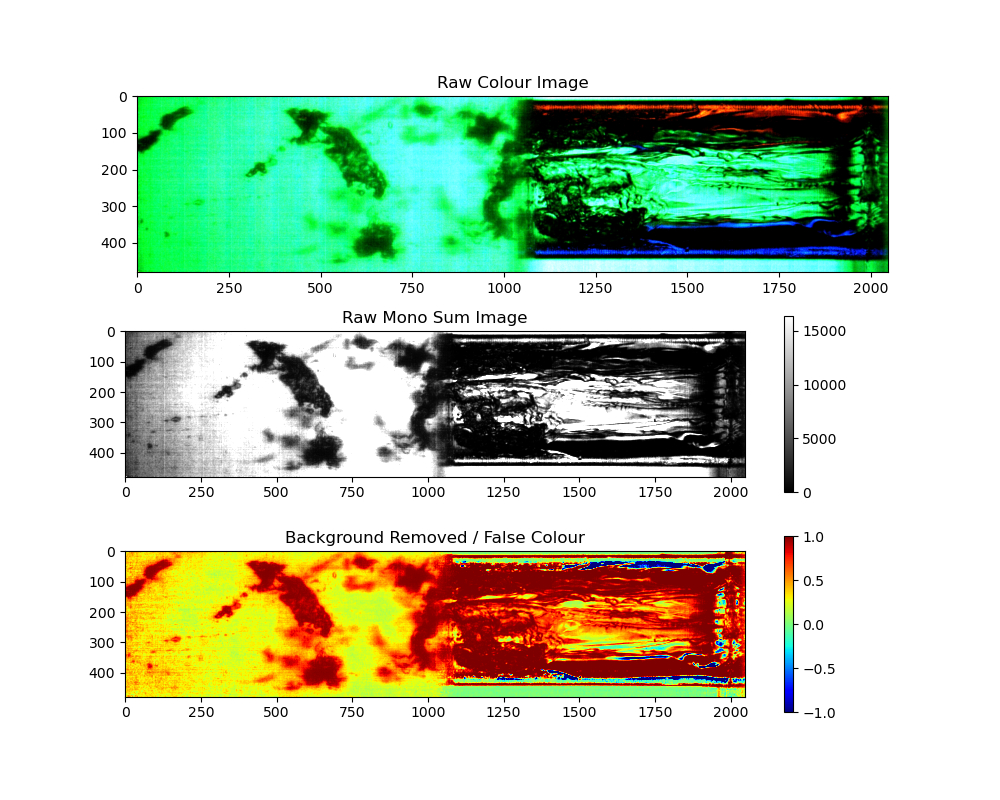

In [201]:
# Plot our progress
n=0 # frame to show

fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(311)
ax.set_title("Raw Colour Image")
Isample = I.arr[n,...]
ax.imshow(mplColor(I.arr[n,...])*10) # x10 just brightens it up a bit
ax=fig.add_subplot(312)
ax.set_title("Raw Mono Sum Image")
p=ax.imshow(Imono[n,...],cmap='grey',vmin=0,vmax=Imono[n,...].max()/4) # /4 brightens it a bit
plt.colorbar(p);
ax=fig.add_subplot(313)
ax.set_title("Background Removed / False Colour")
p=ax.imshow(Iproc[n,...],cmap='jet',vmin=-1,vmax=1) # False colour lets us see the hidden detail in bright/dark area
plt.colorbar(p);
plt.subplots_adjust(hspace=0.25);

# Check to see the effect of the background threshold

The actual intensity values are different to those in MATLAB due to using a different software to read the TIFF.
So the values are arbitrary.

The left column of images shows the result if the full intensity range is viewed. The right column shows only the bracketed range [0,1] where most of the data lies.

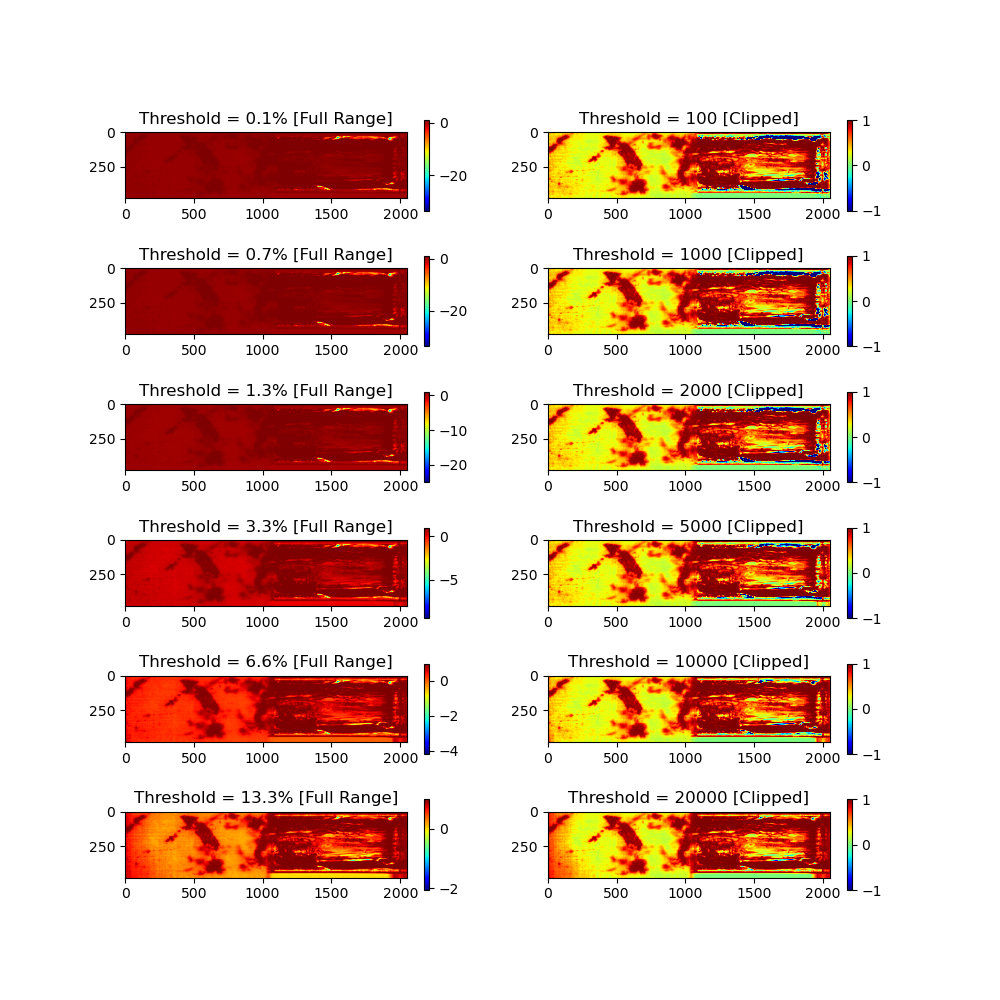

In [205]:
n=0 # frame to show
fig=plt.figure(figsize=(10,10))

thresholds = [100,1000,2000,5000,10000,20000]

for i in range(len(thresholds)):

    threshold = thresholds[i]
    tnorm = 100*threshold/np.nanmax(Bavg_monoAdj)
    Bavg_monoAdj = copy.deepcopy(Bavg_mono[...])
    Bavg_monoAdj[Bavg_monoAdj<threshold]=threshold
    IprocN = 1.0 - (Imono[n,...] / Bavg_monoAdj)
    ax=fig.add_subplot(int(len(thresholds)),2,i*2 + 1)
    ax.set_title("Threshold = %.1f%% [Full Range]" % tnorm)
    p=ax.imshow(IprocN,cmap='jet');
    plt.colorbar(p);

    ax=fig.add_subplot(int(len(thresholds)),2,i*2 + 2)
    ax.set_title("Threshold = %i [Clipped]" % threshold)
    p=ax.imshow(IprocN,cmap='jet',vmin=-1,vmax=1);
    plt.colorbar(p);

plt.subplots_adjust(hspace=0.5)

## Plot histograms of the data

Repeat the previous exercise but show the intensity histogram of all the data rather than a sample image. Check for clipping of intensities...

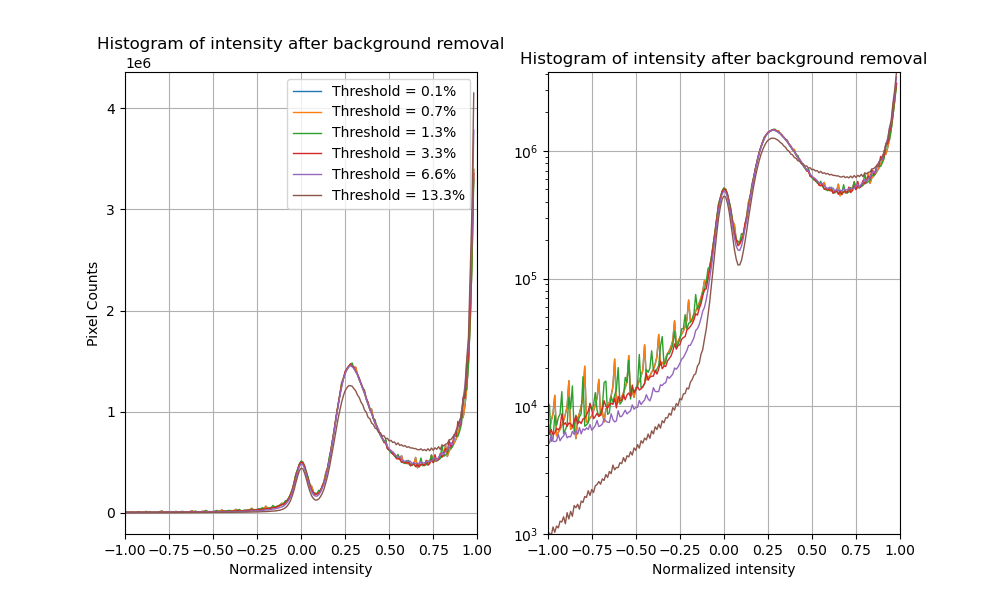

In [207]:
fig=plt.figure(figsize=(10,6))
ax1=fig.add_subplot(121)
plt.xlabel("Normalized intensity")
plt.xlim(-1,1)
plt.ylabel('Pixel Counts')
plt.title("Histogram of intensity after background removal")
plt.grid();
ax2=fig.add_subplot(122)
plt.xlabel("Normalized intensity")
plt.xlim(-1,1)
plt.title("Histogram of intensity after background removal")
plt.grid();

thresholds = [100,1000,2000,5000,10000,20000]


for i in range(len(thresholds)):

    threshold = thresholds[i]
    tnorm = 100*threshold/np.nanmax(Bavg_monoAdj)
    Bavg_monoAdj = copy.deepcopy(Bavg_mono[...])
    Bavg_monoAdj[Bavg_monoAdj<threshold]=threshold
    Iproc = 1.0 - (Imono[...] / Bavg_monoAdj)

    hist, bin_edges = np.histogram(np.ravel(Iproc),bins=np.arange(-10,1,0.01))
    ax1.plot(bin_edges[:-1],hist,label="Threshold = %.1f%%" % tnorm, lw=1)
    ax2.plot(bin_edges[:-1],hist,label="Threshold = %.1f%%" % tnorm, lw=1)

ax1.legend();
ax2.set_yscale('log')
ax2.set_ylim(1e3,hist.max());


We can estimate from the above that the intensity floor applied to the background ought to be in the range of 3-8% of the maximum recorded intensity level. Too low threhold causes large negative values. Too high threshold reduces the effectiveness of the background correction at the edges of the image, leading to nonuniform background level. Notice how 13.3% result deviates from the others. The threshold being less than about 3% has almost no effect.
